In [16]:
import DESTiler

#tiler=DESTiler.DESTiler("DES_DR1_TILE_INFO.csv")


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy import wcs
from astropy.nddata import Cutout2D
import os, sys
import pickle as pk
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.coordinates import SkyCoord
import yaml
from pixell import enmap,utils, reproject, enplot
from scipy import interpolate
import random
from astropy.nddata import block_reduce, block_replicate

import pickle as pk

from PIL import Image

from astLib import astWCS, astImages
from scipy import ndimage

from pixell.enmap import sky2pix

from astropy.wcs import WCS

from stamping_utils import autotiler, getTileCoordsDict, make_jpg, normalize_map

%load_ext autoreload
%autoreload 2

%matplotlib inline



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
tileDefinitions = {"mask": '/project/s/sievers/kaper/mlclusters/ml-clusters/DR5_cluster-search-area-mask_v1.0.fits',
                  "targetTileWidthDeg": 5.0, 
                  "targetTileHeightDeg": 5.0}
hdu = fits.open('./DR5_cluster-search-area-mask_v1.0.fits')
mask = hdu[1].data
wcs_mask = astWCS.WCS(hdu[1].header,mode="pyfits")
w = WCS(hdu[1].header)
tileOverlapDeg = 1

In [3]:
tilelist = autotiler(mask,wcs_mask,tileDefinitions["targetTileWidthDeg"],tileDefinitions["targetTileHeightDeg"])

In [4]:
clipCoordsDict=getTileCoordsDict(tilelist,wcs_mask,tileOverlapDeg)

In [ ]:
for key in clipCoordsDict.keys():
    minX, maxX, minY, maxY=clipCoordsDict[key]['clippedSection']
    ra_min, dec_max = wcs_mask.pix2wcs(maxX, maxY)
    ra_max, dec_min = wcs_mask.pix2wcs(minX, minY)
    print(ra_max, ra_min)

    if ra_max < ra_min:
        print('here')
        ra_min -= 360
    
    box = np.array([[dec_min, ra_min],[dec_max, ra_max]]) * utils.degree
    #c1 = SkyCoord(ra_min, dec_min, frame='icrs', unit='deg')
    #c2 = SkyCoord(ra_max, dec_max, frame='icrs', unit='deg')

    #print(dec_min, dec_max)
    #print(c1.ra.hms, c2.ra.hms)
    print(box)
    #Make jpg of box
    jpg = make_jpg('/home/r/rbond/sigurdkn/project/actpol/map_coadd/20211219/release/', box)
    if type(jpg) == int: continue
    #plt.imshow(jpg[...,0])
    #plt.show()
    #plt.close()
    im = Image.fromarray(jpg, 'RGB')
    im.save("/project/r/rbond/jorlo/datasets/ACT_tiles/{}.jpg".format(key))
    
    #plt.imshow(jpg)
    #plt.show()
    #plt.close()

# Cluster Centered Stamps

In [3]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')
ras, decs = act_catalog[1].data['RADeg'], act_catalog[1].data['decDeg']

In [24]:
to_return_90 = []

map_path = '/home/r/rbond/sigurdkn/project/actpol/map_coadd/20211219/release/'

cur_map = enmap.read_map(map_path + 'act_planck_daynight_f{}_map.fits'.format('090'))[0]

for i, name in enumerate(act_catalog[1].data['name']):
    width = 5.0*utils.arcmin
    
    ra, dec = ras[i]*u.deg, decs[i]*u.deg    

    stamp = reproject.thumbnails(cur_map, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    stamp = normalize_map(stamp)
    to_return_90.append(stamp)
    
to_return_90 = np.stack(to_return_90, axis=0)

to_return_150 = []

map_path = '/home/r/rbond/sigurdkn/project/actpol/map_coadd/20211219/release/'

cur_map = enmap.read_map(map_path + 'act_planck_daynight_f{}_map.fits'.format('150'))[0]

for i, name in enumerate(act_catalog[1].data['name']):
    width = 5.0*utils.arcmin
    
    ra, dec = ras[i]*u.deg, decs[i]*u.deg    

    stamp = reproject.thumbnails(cur_map, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    stamp = normalize_map(stamp)
    to_return_150.append(stamp)
    
to_return_150 = np.stack(to_return_150, axis=0)

to_return_220 = []

map_path = '/home/r/rbond/sigurdkn/project/actpol/map_coadd/20211219/release/'

cur_map = enmap.read_map(map_path + 'act_planck_daynight_f{}_map.fits'.format('220'))[0]

for i, name in enumerate(act_catalog[1].data['name']):
    width = 5.0*utils.arcmin
    
    ra, dec = ras[i]*u.deg, decs[i]*u.deg    

    stamp = reproject.thumbnails(cur_map, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    stamp = normalize_map(stamp)
    to_return_220.append(stamp)
    
to_return_220 = np.stack(to_return_220, axis=0)

In [25]:
to_return = np.stack([to_return_90, to_return_150, to_return_220], axis = -1)

In [27]:
to_return.shape

In [28]:
np.savez_compressed('/project/r/rbond/jorlo/datasets/act_freq_stamps/all_clusters.npz', to_return)

# Single Cluster y stamps

In [18]:
path = '/project/r/rbond/jorlo/S18d_202006/filteredMaps/'

ymap = enmap.read_map(path + 'stitched_Arnaud_M2e14_z0p4_filteredMap.fits')

In [19]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')
ras, decs = act_catalog[1].data['RADeg'], act_catalog[1].data['decDeg']

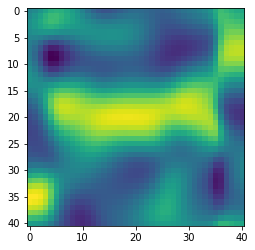

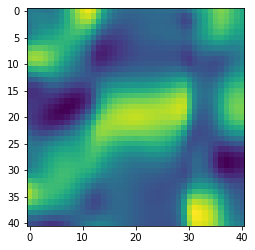

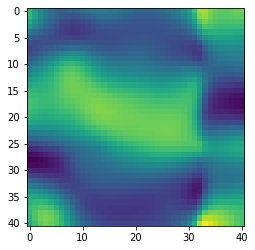

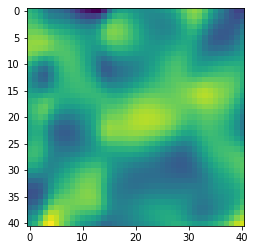

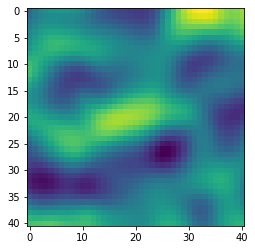

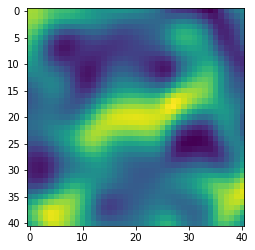

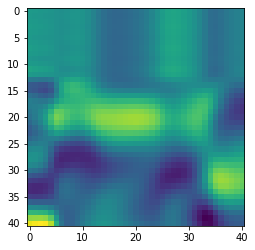

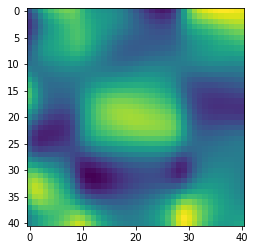

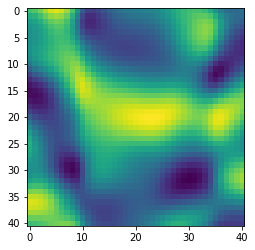

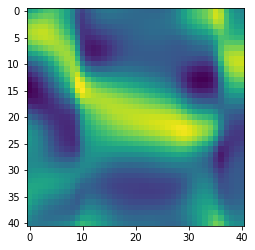

In [45]:
to_return_y = []

for i in range(10):
    width = 5.0*utils.arcmin
    
    ra, dec = ras[i]*u.deg, decs[i]*u.deg    

    stamp = reproject.thumbnails(ymap, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    stamp = normalize_map(stamp)
    plt.imshow(stamp)
    plt.show()
    plt.close()
    #stamp = normalize_map(stamp)

    to_return_y.append(stamp)
to_return_y = np.stack(to_return_y, axis=0)

pk.dump(to_return_y, open('/project/r/rbond/jorlo/datasets/act_y_stamps/test_clusters.pk', 'wb'))

In [46]:
to_return_y = []

for i, name in enumerate(act_catalog[1].data['name']):
    width = 5.0*utils.arcmin
    
    ra, dec = ras[i]*u.deg, decs[i]*u.deg    

    stamp = reproject.thumbnails(ymap, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    #stamp = normalize_map(stamp)
    to_return_y.append(stamp)

to_return_y = np.stack(to_return_y, axis=0)

In [47]:
to_return_y.shape

(4195, 41, 41)

In [48]:
np.savez_compressed('/project/r/rbond/jorlo/datasets/act_y_stamps/all_clusters.npz', to_return_y)

In [5]:
#Paths to a couple coadded maps

#path = '/home/r/rbond/sigurdkn/project/actpol/map_coadd/20200228/release2/'
path = '/home/r/rbond/sigurdkn/project/actpol/map_coadd/20211219/release/'
#path = '/project/r/rbond/jorlo/stitched_Beam_filteredMap.fits'
freqs = ['220', '150', '090']

#Unused code for taking a look at the maps
#cur_map = enmap.read_map(path + 'act_planck_s08_s19_cmb_f{}_night_map.fits'.format(freqs[2]))
cur_map = enmap.read_map(path + 'act_planck_daynight_f{}_map.fits'.format(freqs[2]))

cur_map = cur_map[0]

#plots = enplot.plot(cur_map,range=300,mask=0)
#enplot.write("plots_example",plots)

#def eshow(x,**kwargs): enplot.show(enplot.plot(x,**kwargs))
#enplot.show(enplot.plot(cur_map))

In [6]:
cur_map.wcs

In [11]:
from astropy.utils.data import get_pkg_data_filename

wcs = cur_map.wcs

plt.subplot(projection=wcs)
plt.imshow(cur_map, vmin=-300, vmax=300)#, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')

In [11]:
hdu.header

In [12]:
plt.imshow(cur_map[0], vmin = -300, vmax = 300)

In [26]:

#Create a box
ra_min = 0; ra_max = 10; dec_min=0; dec_max=10
box = np.array([[dec_min,ra_min],[dec_max,ra_max]]) * utils.degree
box = [[-1.0645054,   0.94960714], [-0.93651459,  1.25052841]]
print(box)
#Make jpg of box
jpg = make_jpg('/home/r/rbond/sigurdkn/project/actpol/map_coadd/20211219/release/', box)

#The image package allows us to turn the array into a jpg for saving
im = Image.fromarray(jpg, 'RGB')
im.save("test_jpg.jpeg")

In [27]:
cur_map = enmap.read_map(path + 'act_planck_daynight_f{}_map.fits'.format(freqs[2]), box = box)

cur_map = cur_map[0]

from astropy.utils.data import get_pkg_data_filename

wcs = cur_map.wcs

plt.subplot(projection=wcs)
plt.imshow(cur_map, vmin=-300, vmax=300)#, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')

In [25]:
jpg.shape

In [14]:
plt.imshow(jpg[...,2])
plt.colorbar()

In [15]:
np.amax(jpg[...,2])

In [11]:
for i in range(0, 360, 10):
    ra_min = i; ra_max = i+10
    dec_min = 0; dec_max = 10
    #TODO: Galaxy masking
    box = np.array([[dec_min,ra_min],[dec_max,ra_max]]) * utils.degree
    cur_map = enmap.read_map(path + 'act_planck_daynight_f{}_map.fits'.format(freqs[2]), box=box)
    plt.imshow(cur_map[0], vmin=-300, vmax = 300)
    plt.show()
    plt.close()

In [6]:
plt.imshow(cur_map[0], vmin=-300, vmax = 300)

In [12]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

actRa = act_catalog[1].data['RADeg']
actNames = act_catalog[1].data['name']
actDec = act_catalog[1].data['decDeg']
actRa, actDec = np.array(actRa), np.array(actDec)
actSnr = act_catalog[1].data['fixed_SNR']
actz = act_catalog[1].data['redshift']

In [13]:
#path = '/project/r/rbond/jorlo/S18d_202006/filteredMaps/'

#tileName = tileFinder(actRa[0], actDec[0], s18d)
#tile = enmap.read_map(path+tileName+'/Arnaud_M2e14_z0p4#'+tileName+'_filteredMap.fits')
ra, dec = actRa[0]*u.deg, actDec[0]*u.deg
stamp = reproject.thumbnails(cur_map, ( dec.to(u.radian).value,ra.to(u.radian).value), r=5*utils.arcmin,
                            apod = 2*utils.arcmin)#5.*np.pi/(60*180))
#plot = enplot.plot(stamp)
#enplot.show(plot)

In [17]:
plt.imshow(stamp[0])
print(stamp.shape)
plt.colorbar()

In [31]:
print(min(np.abs(stamp.wcs.wcs.cdelt))*utils.degree/2)
print(min(np.abs(stamp.wcs.wcs.cdelt))*utils.degree/2*(3600 * 180)/np.pi)
print(0.004167*(60 * 180)/np.pi)

In [32]:
print(10/41*60)

In [33]:
print(cur_map.wcs.wcs.cdelt)
print(stamp.wcs.wcs.cdelt)

In [34]:
ra, dec = actRa[0], actDec[0]
stamp1 = freq_cutout(ra, dec, cur_map, scale = 399, width = 5*utils.arcmin)
plt.imshow(stamp1)
print(stamp.shape)

In [ ]:
stamp2 = freq_cutout(ra, dec, cur_map, scale = 399, width = 5*utils.arcmin)
plt.imshow(stamp2)
print(stamp.shape)

In [ ]:
plt.imshow((stamp1-stamp2)/stamp1)
plt.colorbar()



In [ ]:
stamp = 0
for i in range(len(actRa)):
    ra, dec = actRa[i]*u.deg, actDec[i]*u.deg
    full_box  = reproject.thumbnails(cur_map, (dec.to(u.radian).value, ra.to(u.radian).value), r=20.*np.pi/(60*180))
    stamp+=full_box

In [ ]:
plt.imshow(stamp)

In [ ]:
path = '/home/r/rbond/sigurdkn/project/actpol/map_coadd/20200228/release2/'

freq_map_090 = enmap.read_map(path + 'act_planck_s08_s19_cmb_f090_night_map.fits')
freq_map_150 = enmap.read_map(path + 'act_planck_s08_s19_cmb_f150_night_map.fits')
freq_map_220 = enmap.read_map(path + 'act_planck_s08_s19_cmb_f220_night_map.fits')

temp = cutout(actRa[:2], actDec[:2], freq_map_090, freq_map_150, freq_map_220, scale = 10)

In [ ]:
for i in range(8):
    plt.imshow(temp[1][...,i])
    plt.show()
    plt.close()

In [ ]:
temp[0][7]-temp[1][7]

In [ ]:
temp[1][6]